In [227]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

import nltk, re, string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import tokenization

Num GPUs Available:  0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\w2673\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\w2673\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [228]:
# Load the data
with open('train.csv', 'rb') as f:
    train_df = pd.read_csv(f)
with open('test.csv', 'rb') as f:
    test_df = pd.read_csv(f)
# train_df = pd.read_csv('train.csv', encoding="ISO-8859-1")
# test_df = pd.read_csv('test.csv', encoding="ISO-8859-1")

In [229]:
# train and text shapes
train_df.shape, test_df.shape

((7613, 5), (3263, 4))

In [230]:
# Check the duplicated tweets
dup_train = train_df['text'].duplicated().sum()
print(f'there are {dup_train} tweets duplicated in train_df.')

there are 110 tweets duplicated in train_df.


In [231]:
# drop duplictes
train_df = train_df.drop_duplicates(subset=['text'], keep='first')

In [232]:
# new shape for train data
train_df.shape, test_df.shape

((7503, 5), (3263, 4))

In [233]:
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


0    4305
1    3198
Name: target, dtype: int64

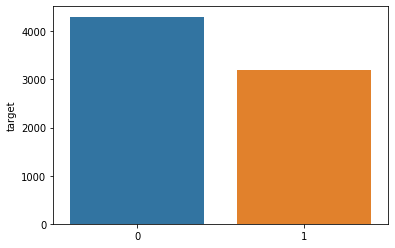

In [234]:
# check the distribution of the disaster and no-disaster tweets
count = train_df['target'].value_counts()
sns.barplot(count.index, count)
count

In [235]:
# Cleaning the data and removing the stopwords
def Data_Cleaning(text):
    text = text.lower()
    text = re.sub("won\'t", "will not", text)
    text = re.sub("can\'t", "can not", text)
    text = re.sub("don\'t", "do not", text)
    
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+',' ', text)
    text = re.sub(r'&amp?;',' ', text)
    text = re.sub(r'&lt;',' ', text)
    text = re.sub(r'&gt;',' ', text)
    
    text = re.sub(r'\d{2}:\d{2}:\d{2}', ' ', text)
    text = re.sub(r'UTC', ' ', text)
    text = re.sub(r'\d{2}km', ' ', text)
    text = re.sub(r"\b\d+\b", " ", text) # removing the numbers

    text = re.sub(r"#","",text) 
    text = re.sub(r"(?:\@)\w+", ' ', text)
    text = re.sub(r'\n', ' ', text)
    
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    text = re.sub(' +', ' ', text) # remove multiple spaces
    
    text = [word for word in word_tokenize(text) if not word in stopwords.words('english')]
    text = ' '.join(text)

    return text

In [236]:
# apply the cleaning function to the dataset and creating a new column of the cleaned data
train_df['cleaned'] = train_df['text'].apply(lambda x: Data_Cleaning(x))
test_df['cleaned'] = test_df['text'].apply(lambda x: Data_Cleaning(x))

In [237]:
train_df.tail(10)

,id,keyword,location,text,target,cleaned
7598,10853,NaN,NaN,Father-of-three Lost Control of Car After Over...,1,father three lost control car overtaking colli...
7599,10854,NaN,NaN,1.3 #Earthquake in 9Km Ssw Of Anza California ...,1,earthquake 9km ssw anza california iphone user...
7601,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1,breaking la refugio oil spill may costlier big...
7602,10860,NaN,NaN,a siren just went off and it wasn't the Forney...,1,siren went forney tornado warning
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1,officials say quarantine place alabama home po...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,worldnews fallen powerlines g link tram update...
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1,flip side walmart bomb everyone evacuate stay ...
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,suicide bomber kills saudi security site mosqu...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1,latest homes razed northern california wildfir...


In [238]:
test_df.head()

,id,keyword,location,text,cleaned
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan


In [239]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    masks = []
    segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        masks.append(pad_masks)
        segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(masks), np.array(segments)

In [240]:
# tokenizer from tokenization script
F_tokenizer = tokenization.FullTokenizer

In [241]:
# 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
hub_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
bert_layer = hub.KerasLayer(hub_url, trainable=True)

In [242]:
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
vocabulary = bert_layer.resolved_object.vocab_file.asset_path.numpy()

tokenizer = F_tokenizer(vocabulary, to_lower_case)

In [243]:
def build_model(bert_layer, max_len=512):
    
    input_word_ids = Input(shape = (max_len,), dtype = tf.int32, name = "input_word_ids")
    input_mask = Input(shape = (max_len,), dtype = tf.int32, name = "input_mask")
    segment_ids = Input(shape = (max_len,), dtype = tf.int32, name = "segment_ids")

    pooled_sequence, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    output = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs = output)
    model.compile(Adam(lr=1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [244]:
df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
max_length = len(max(df.cleaned, key=len))
max_length

138

In [245]:
train_input = bert_encode(train_df.cleaned.values, tokenizer, max_len=140)
test_input = bert_encode(test_df.cleaned.values, tokenizer, max_len=140)
train_labels = train_df['target'].values

In [246]:
model = build_model(bert_layer, max_len=140)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 140)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 140)]        0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [247]:
checkpoint = ModelCheckpoint('model.h5', monitor = 'val_loss', save_best_only = True)
train_history = model.fit(train_input, train_labels, validation_split = 0.25, epochs = 5, callbacks = [checkpoint], batch_size = 16)

Epoch 1/5
352/352 [==============================] - 4721s 13s/step - loss: 0.4475 - accuracy: 0.8015 - val_loss: 0.4019 - val_accuracy: 0.8273
Epoch 2/5
352/352 [==============================] - 4247s 12s/step - loss: 0.2904 - accuracy: 0.8802 - val_loss: 0.4411 - val_accuracy: 0.8156
Epoch 3/5
352/352 [==============================] - 4285s 12s/step - loss: 0.1369 - accuracy: 0.9508 - val_loss: 0.4935 - val_accuracy: 0.8161
Epoch 4/5
352/352 [==============================] - 4692s 13s/step - loss: 0.0724 - accuracy: 0.9735 - val_loss: 0.6928 - val_accuracy: 0.7900
Epoch 5/5
352/352 [==============================] - 4699s 13s/step - loss: 0.0476 - accuracy: 0.9799 - val_loss: 0.7194 - val_accuracy: 0.8134


In [248]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

In [249]:
submission = pd.read_csv('sample_submission.csv')

In [250]:
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)